<a href="https://colab.research.google.com/github/nqa112/MandevicesLab-AI/blob/main/DogCatClassification_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import shutil
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, BatchNormalization, Activation
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Download dataset from Kaggle, creating API on Kaggle is needed
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d biaiscience/dogs-vs-cats -p '/content/drive/MyDrive'

     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 4.2MB 43.2MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 112kB 54.7MB/s 
     |████████████████████████████████| 143kB 56.1MB/s 
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-gshar94a/lxml/setup.py'"'"'; __file__='"'"'/tmp/pip-install-gshar94a/lxml/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-pzsajxi7/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.
{"username":"nqa112","key":"96061b5a34c95b4b06c21384ce297ddc"}Downloading dogs-vs-cats.zip to /cont

In [ ]:
!unzip -q '/content/drive/MyDrive/Assignment3/dogs-vs-cats.zip' -d '/content/drive/MyDrive/AI/input'
print('Done.')


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/Shareddrives/Shared/htccd/General _ Microsoft Teams 2021-10-20 15-45-56.rar

Extracting  /content/drive/Shareddrives/Shared/htccd/General _ Microsoft Teams 2021-10-20 15-45-56.mp4       0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88%

In [ ]:
# Check PIL unidentified images to avoid error while training
from PIL import Image
folder_path = '/content/drive/MyDrive/bigInput/train/train'  # Write the folder where your picture is located, that is, the folder containing the image
extensions = []
for filee in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filee)
    print('** Path: {}  **'.format(file_path), end="\r", flush=True)
    im = Image.open(file_path)
    rgb_im = im.convert('RGB')
    if filee.split('.')[1] not in extensions:
        extensions.append(filee.split('.')[1])
print('done')

In [ ]:
# Delete unidentified images
path = '/content/drive/MyDrive/Assignment3/vgg16_1.h5'
if os.path.exists(path):
  os.remove(path)
else:
  print("The file does not exist")

In [ ]:
# Split cat and dog images to folders respectively
src = '/content/drive/MyDrive/AI/input/train/train' #folder containing both dogs and cats
chr = 'dog'

#create new folder with corresponding class
des = os.path.join(src,chr.upper()) 
os.makedirs(des)

#move images from source folder to corresponding class folder
for f in os.listdir(src):
    if chr in f:
      shutil.move(os.path.join(src,f), os.path.join(des,f))
    else:
      continue 
print('Done')

Done


In [ ]:
!ls /content/drive/Shareddrives/Shared/train/train # Check files and sub folders

CAT  DOG


In [ ]:
# Check the number of images in train and test folder
# Validation images will be created by flow_from_directory trick
numTrain_dog = len(os.listdir('/content/drive/Shareddrives/Shared/train/train/DOG'))
numTrain_cat = len(os.listdir('/content/drive/Shareddrives/Shared/train/train/CAT'))
numTest = len(os.listdir('/content/drive/Shareddrives/Shared/test/test'))

print('There are %d dog images for training' %(numTrain_dog))
print('There are %d cat images for training' %(numTrain_cat))
print('There are %d images for test' %(numTest))

There are 12500 dog images for training
There are 12500 cat images for training
There are 12500 images for test


In [ ]:
# Set up some variables
image_size = (224,224)
batch_size = 32
epoch = 20

In [ ]:
# Generate train and validation batches with augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

trainData = train_datagen.flow_from_directory('/content/drive/Shareddrives/Shared/train/train',
                                                target_size = image_size,
                                                batch_size = batch_size,
                                                shuffle = True,
                                                seed = 42,
                                                class_mode = 'binary',
                                                subset = 'training'
                                                )

valData = test_datagen.flow_from_directory('/content/drive/Shareddrives/Shared/train/train',
                                            target_size = image_size,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            seed = 42,
                                            class_mode = 'binary',
                                            subset = 'validation'
                                            )
trainData.class_indices # Dictionary containing the mapping from class names to class indices

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


{'CAT': 0, 'DOG': 1}

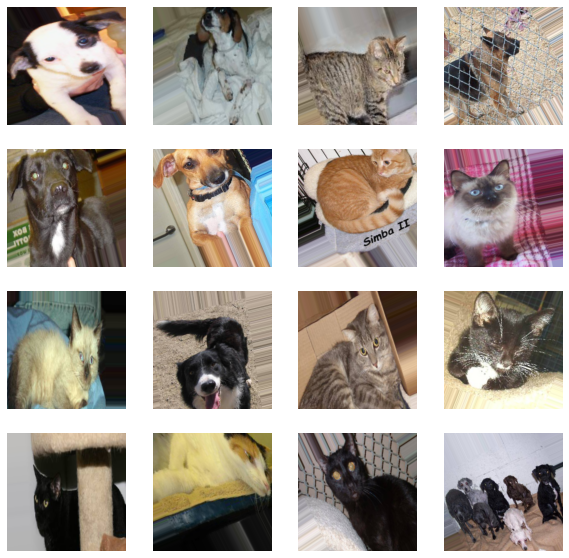

In [ ]:
# Visualize generated data
fig = plt.figure(figsize=(10,10))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img, label = trainData.next()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img[0].astype('float32'))
    plt.axis('off')
plt.show()

In [ ]:
#build VGG-16 from scratch
model =Sequential()

model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same"))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(units=4096))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(units=1, activation="sigmoid"))

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
checkpoint = ModelCheckpoint("/content/drive/Shareddrives/Shared/vgg16.h5", 
                             monitor='val_accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False, 
                             mode='max')

early = EarlyStopping(monitor='val_loss', 
                      min_delta=0, 
                      patience=5,
                      verbose=1, 
                      mode='min')

log = CSVLogger('/content/drive/Shareddrives/Shared/training.log', 
                separator=',', 
                append=False)

hist = model.fit(trainData, 
                 epochs = epoch,
                 steps_per_epoch= trainData.samples // batch_size, 
                 callbacks=[checkpoint,early,log], 
                 validation_data=valData,
                 validation_steps= valData.samples // batch_size)

Epoch 1/20
625/625 [==============================] - 590s 938ms/step - loss: 0.6353 - accuracy: 0.6324 - val_loss: 0.7376 - val_accuracy: 0.5465

Epoch 00001: val_accuracy improved from -inf to 0.54647, saving model to /content/drive/Shareddrives/Shared/vgg16.h5
Epoch 2/20
625/625 [==============================] - 588s 940ms/step - loss: 0.5329 - accuracy: 0.7391 - val_loss: 0.5459 - val_accuracy: 0.7472

Epoch 00002: val_accuracy improved from 0.54647 to 0.74720, saving model to /content/drive/Shareddrives/Shared/vgg16.h5
Epoch 3/20
625/625 [==============================] - 588s 941ms/step - loss: 0.4706 - accuracy: 0.7804 - val_loss: 0.5357 - val_accuracy: 0.7596

Epoch 00003: val_accuracy improved from 0.74720 to 0.75962, saving model to /content/drive/Shareddrives/Shared/vgg16.h5
Epoch 4/20
625/625 [==============================] - 588s 941ms/step - loss: 0.4169 - accuracy: 0.8140 - val_loss: 0.5816 - val_accuracy: 0.6927

Epoch 00004: val_accuracy did not improve from 0.75962


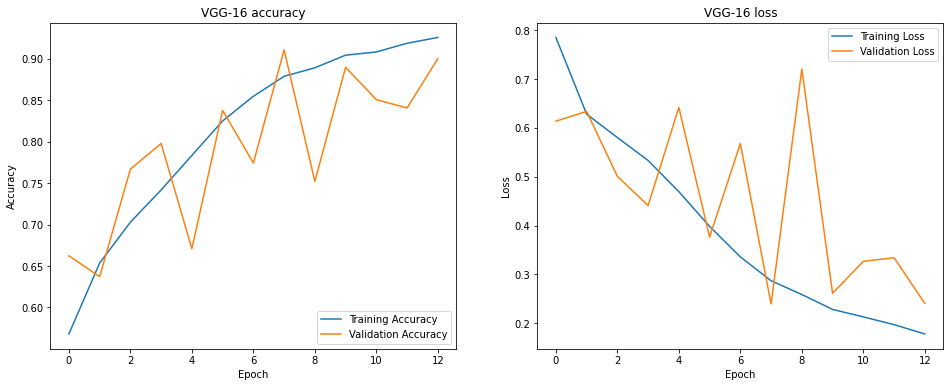

In [ ]:
# Visualize model training process by history key, but only available in current GG Colab runtime
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc='lower right')
plt.title('VGG-16 accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc='upper right')
plt.title('VGG-16 loss')
plt.show()

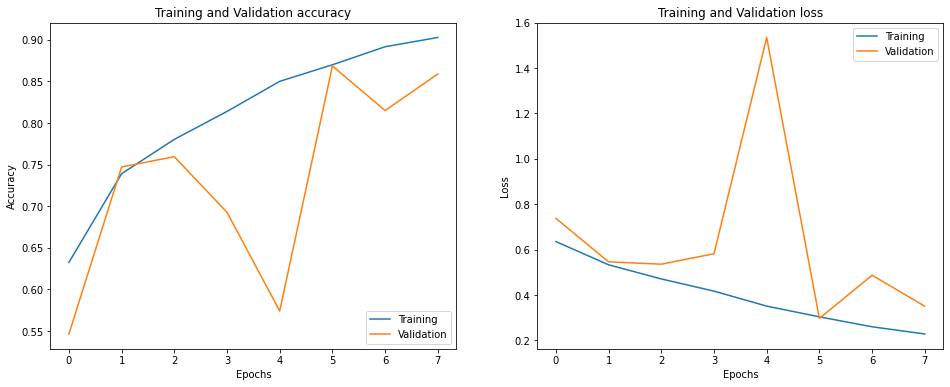

In [ ]:
# You can also visualize model training process with csv .log file, which was saved during training
df = pd.read_csv('/content/drive/Shareddrives/Shared/training.log')

acc = df[['accuracy']]
val_acc = df[['val_accuracy']]

loss = df[['loss']]
val_loss = df[['val_loss']]

epochs_range = df[['epoch']]

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

In [ ]:
# input must equal to input shape of VGG-16
image_size = (224,224)
saved_model = load_model("/content/drive/Shareddrives/Shared/vgg16.h5")

THIS IS DOG



array([1.], dtype=float32)

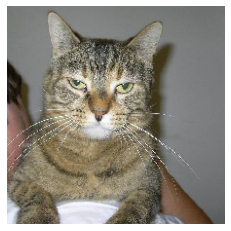

In [ ]:
# Image prediction
img = image.load_img("/content/drive/Shareddrives/Shared/train/train/CAT/cat.5555.jpg", target_size=image_size)
img = np.asarray(img)
plt.imshow(img)
plt.axis('off')
img = np.expand_dims(img, axis=0)
output = saved_model.predict(img)
if output[0][0] < 0.5:
    print('THIS IS CAT\n')
else:
    print('THIS IS DOG\n')